In [1]:
# Standard imports
from helper_files import *       # Custom helper functions (not shown here)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdmn
from matplotlib.gridspec import GridSpec
import forestplot as fp
from matplotlib.ticker import AutoMinorLocator

# Set higher-resolution figure display in notebooks
%config InlineBackend.figure_format = 'svg' 

# Set default plotting style
plt.style.use('default')

# Define the date folder and data directory
up_DATA_DIR     = "./dataset/"

# Load declarations data and get maximum date
upd_df_decs, max_date = load_declarations(up_DATA_DIR)

# Define color and label dictionaries
color_dic = {
    "user": 'C0',
    "task": 'C1',
    "prjt": 'C2',
    "team": 'C3',
    "edge": 'C4'
}

dic_rename = {
    "log_nb_tasks":   "no. tasks (log)",
    "log_nb_users":   "no. users (log)",
    "diversity":      "team diversity",
    "mean_exp":       "team experience",
    "duration":       "average no. hours in a declaration",
    "daily_duration": "daily average no. hours per task",
    "log_nb_days":    "no. individual days of activity (log)",
    "log_lftm":       "timespan of activity (log)",
    "log_nb_decs":    "no. individual declarations (log)",
}

created_min 2017-12-11 00:00:00
created_max 2024-10-10 00:00:00
# users 12414
# tasks 173323
# projects 50759
# decs 4428885


  1%|█                                                                                                                                                                   | 30001/4428885 [00:00<00:15, 287014.14it/s]

# user-days 811924


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4428885/4428885 [00:07<00:00, 625592.51it/s]


In [2]:
# 1) Compute the cumulative number of unique teams as we move through time.
team_date = (
    upd_df_decs
    .groupby("created_at")["team_id"]
    .unique()
    .reset_index()
)
team_date["nb_teams"] = [
    len(
        set([v for k in team_date.team_id.iloc[:(i + 1)] for v in k])
    )
    for i in range(len(team_date))
]

# 2) Compute the cumulative number of unique users.
user_date = (
    upd_df_decs
    .groupby("created_at")["user_id"]
    .unique()
    .reset_index()
)
user_date["nb_users"] = [
    len(
        set([v for k in user_date.user_id.iloc[:(i + 1)] for v in k])
    )
    for i in range(len(user_date))
]

# 3) Compute the cumulative number of unique tasks.
task_date = (
    upd_df_decs
    .groupby("created_at")["task_id"]
    .unique()
    .reset_index()
)
task_date["nb_tasks"] = [
    len(
        set([v for k in task_date.task_id.iloc[:(i + 1)] for v in k])
    )
    for i in range(len(task_date))
]

# 4) Compute the cumulative number of unique projects.
proj_date = (
    upd_df_decs
    .groupby("created_at")["project_id"]
    .unique()
    .reset_index()
)
proj_date["nb_projects"] = [
    len(
        set([v for k in proj_date.project_id.iloc[:(i + 1)] for v in k])
    )
    for i in range(len(proj_date))
]

# 5) CCDF distributions for various relationships
ccdf_ut  = ccdf_dist(upd_df_decs, "user_id",    "task_id")
ccdf_up  = ccdf_dist(upd_df_decs, "user_id",    "project_id")
ccdf_ute = ccdf_dist(upd_df_decs, "user_id",    "team_id")

ccdf_tu  = ccdf_dist(upd_df_decs, "task_id",    "user_id")
ccdf_tp  = ccdf_dist(upd_df_decs, "task_id",    "project_id")
ccdf_tte = ccdf_dist(upd_df_decs, "task_id",    "team_id")

ccdf_pu  = ccdf_dist(upd_df_decs, "project_id", "user_id")
ccdf_pt  = ccdf_dist(upd_df_decs, "project_id", "task_id")
ccdf_pte = ccdf_dist(upd_df_decs, "project_id", "team_id")

ccdf_tet = ccdf_dist(upd_df_decs, "team_id",    "task_id")
ccdf_teu = ccdf_dist(upd_df_decs, "team_id",    "user_id")
ccdf_tep = ccdf_dist(upd_df_decs, "team_id",    "project_id")

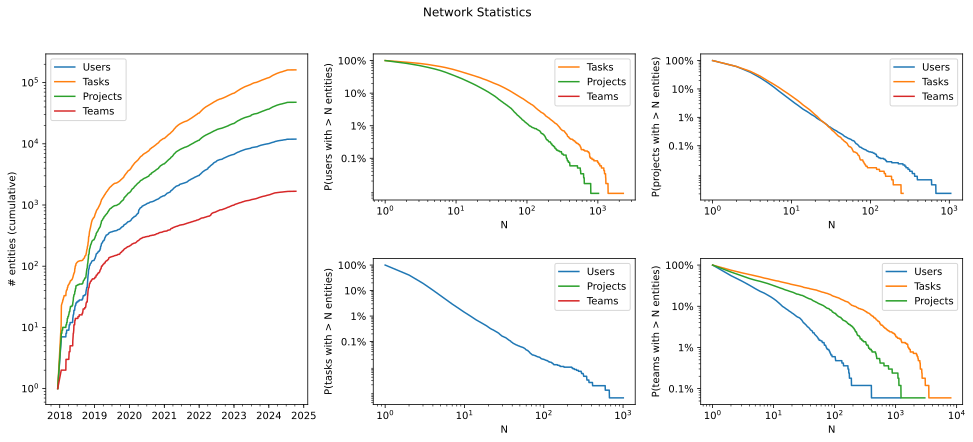

In [3]:
# Use default matplotlib style
plt.style.use("default")

# Create a figure with 2 rows and 3 columns; set constrained_layout to handle spacing
fig = plt.figure(figsize=(15, 6.5))
gs = GridSpec(2, 3, figure=fig)

# Define subplots in the grid
ax0 = fig.add_subplot(gs[:2, 0])  # spans both rows in the first column
ax1 = fig.add_subplot(gs[0, 1])   # top row, second column
ax2 = fig.add_subplot(gs[1, 1])   # bottom row, second column
ax3 = fig.add_subplot(gs[0, 2])   # top row, third column
ax4 = fig.add_subplot(gs[1, 2])   # bottom row, third column

# 1) Plot the cumulative number of each entity type over time
ax0.plot(user_date["created_at"], user_date["nb_users"],     label="Users",    color=color_dic["user"])
ax0.plot(task_date["created_at"], task_date["nb_tasks"],     label="Tasks",    color=color_dic["task"])
ax0.plot(proj_date["created_at"], proj_date["nb_projects"],  label="Projects", color=color_dic["prjt"])
ax0.plot(team_date["created_at"], team_date["nb_teams"],     label="Teams",    color=color_dic["team"])
ax0.set_yscale("log")
ax0.set_ylabel("# entities (cumulative)")
ax0.legend()

# 2) Plot CCDF of users across tasks, projects, teams
ax1.plot(ccdf_ut[0],  ccdf_ut[1],  label="Tasks",    color=color_dic["task"])
ax1.plot(ccdf_up[0],  ccdf_up[1],  label="Projects", color=color_dic["prjt"])
ax1.plot(ccdf_ute[0], ccdf_ute[1], label="Teams",    color=color_dic["team"])
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("N")
ax1.set_ylabel("P(users with > N entities)")
ax1.set_yticks([1e-3,1e-2,1e-1,1e0],["0.1%","1%","10%","100%"])
ax1.legend()

# 3) Plot CCDF of tasks across users, projects, teams
ax2.plot(ccdf_tu[0],  ccdf_tu[1],  label="Users",    color=color_dic["user"])
ax2.plot(ccdf_tp[0],  ccdf_tp[1],  label="Projects", color=color_dic["prjt"])
ax2.plot(ccdf_tte[0], ccdf_tte[1], label="Teams",    color=color_dic["team"])
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("N")
ax2.set_ylabel("P(tasks with > N entities)")
ax2.set_yticks([1e-3,1e-2,1e-1,1e0],["0.1%","1%","10%","100%"])
ax2.legend()

# 4) Plot CCDF of projects across users, tasks, teams
ax3.plot(ccdf_pu[0],  ccdf_pu[1],  label="Users",  color=color_dic["user"])
ax3.plot(ccdf_pt[0],  ccdf_pt[1],  label="Tasks",  color=color_dic["task"])
ax3.plot(ccdf_pte[0], ccdf_pte[1], label="Teams",  color=color_dic["team"])
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("N")
ax3.set_ylabel("P(projects with > N entities)")
ax3.set_yticks([1e-3,1e-2,1e-1,1e0],["0.1%","1%","10%","100%"])
ax3.legend()

# 5) Plot CCDF of teams across users, tasks, projects
ax4.plot(ccdf_teu[0], ccdf_teu[1], label="Users",    color=color_dic["user"])
ax4.plot(ccdf_tet[0], ccdf_tet[1], label="Tasks",    color=color_dic["task"])
ax4.plot(ccdf_tep[0], ccdf_tep[1], label="Projects", color=color_dic["prjt"])
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_xlabel("N")
ax4.set_ylabel("P(teams with > N entities)")
ax4.set_yticks([1e-3,1e-2,1e-1,1e0],["0.1%","1%","10%","100%"])
ax4.legend()

# Give the figure a main title and finalize layout
fig.suptitle("Network Statistics", x=0.5, y=.95)

# Enable minor ticks for all subplots explicitly
fig.subplots_adjust(left=0.1, right=0.95, top=0.85, bottom=0.1, hspace=0.4, wspace=0.25)
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.minorticks_on()

fig.savefig("./figures/network_stats.pdf", bbox_inches="tight");

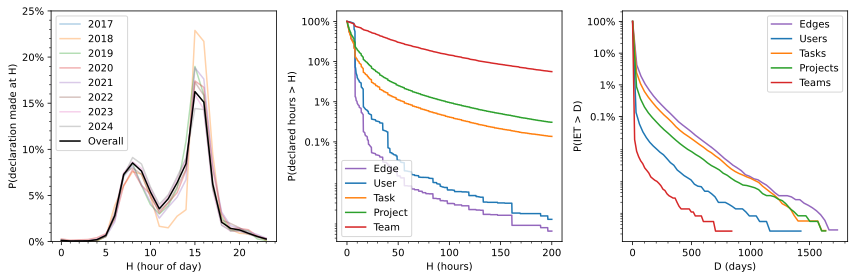

In [4]:
# Create a figure with 1 row and 3 columns
f, axes = plt.subplots(1, 3, figsize=(12, 4))

# 1) Hourly declarations (percentage) per year
for year in upd_df_decs["year"].drop_duplicates().sort_values():
    (
        100 * upd_df_decs[upd_df_decs.year == year].groupby("hour").size() 
        / float(upd_df_decs[upd_df_decs.year == year].shape[0])
    ).plot(ax=axes[0], alpha=0.35, label=year)

# Plot overall distribution (all years)
(
    100 * upd_df_decs.groupby("hour").size() 
    / float(upd_df_decs.shape[0])
).plot(ax=axes[0], color="k", label="Overall")

axes[0].set_xlabel("H (hour of day)")
axes[0].set_ylabel("P(declaration made at H)")
axes[0].set_ylim([0, 25])
axes[0].set_yticks([0,5,10,15,20,25],["0%", "5%", "10%", "15%", "20%", "25%"]);
axes[0].legend()

# 2) CCDF of total declared hours by group (edge, user, task, project, team)
for (group_col, color_key) in zip(
    ["edge_id", "user_id", "task_id", "project_id", "team_id"],
    ["edge", "user", "task", "prjt", "team"]
):
    x_sum, y_sum = ccdf_sum_dist(upd_df_decs, group_col, "declared_at")
    axes[1].plot(x_sum, y_sum, label=group_col.split("_")[0].title(), color=color_dic[color_key])
    axes[1].set_ylabel("P(declared hours > H)")
    axes[1].set_yscale("log")
    axes[1].set_xlabel("H (hours)")
    axes[1].set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    axes[1].set_yticklabels(["0.1%", "1%", "10%", "100%"])
    axes[1].legend()

# 3) CCDF of inter-event times (IET) by group (edge, user, task, project, team)
for (group_col, color_key) in zip(
    ["edge_id", "user_id", "task_id", "project_id", "team_id"],
    ["edge", "user", "task", "prjt", "team"]
):
    iet_preval = upd_df_decs.groupby(group_col)["declared_at"].apply(iet)
    # Flatten the list of IET values from all groups
    iet_val = [val for sublist in iet_preval.values for val in sublist]
    
    # Define an array of IET values (days) to evaluate the CCDF
    arr_iet = np.linspace(min(iet_val), max(iet_val), num=50)
    ccdf_iet = cont_ccdf(iet_val, arr_iet)
    
    axes[2].plot(arr_iet, ccdf_iet, label=group_col.split("_")[0].title() + "s", color=color_dic[color_key])

axes[2].set_ylabel("P(IET > D)")
axes[2].set_yscale("log")
axes[2].set_xlabel("D (days)")
axes[2].set_yticks([1e-3, 1e-2, 1e-1, 1e0])
axes[2].set_yticklabels(["0.1%", "1%", "10%", "100%"])
axes[2].legend()

# Tighten layout to reduce overlapping
f.tight_layout()
for ax in axes:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.minorticks_on()

f.savefig("./figures/circ_ccdf_hour_iet.pdf", bbox_inches="tight");

17270 out of 40947 tasks were successful
7839 out of 16032 projects were successful


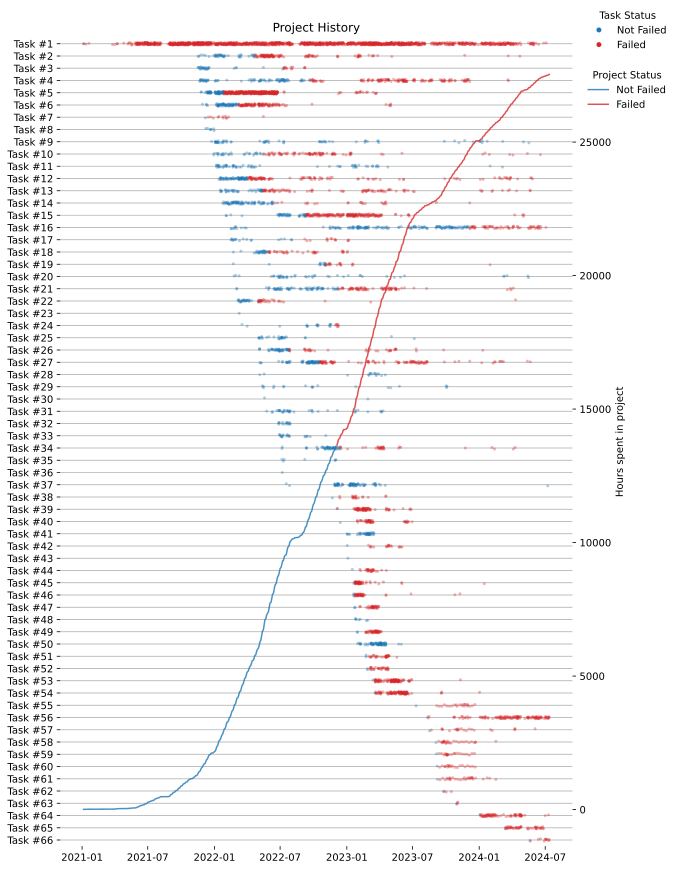

In [5]:
# 1) Load task and project data, compute success/failure flags
df_tasks = generate_task_data(upd_df_decs, max_date, up_DATA_DIR)
df_projects, df_day_proj = generate_project_data(upd_df_decs, max_date, up_DATA_DIR)

df_tasks["failure"]    = 1 - df_tasks["success"]
df_projects["failure"] = 1 - df_projects["success"]

print("%d out of %d tasks were successful" % (
    df_tasks["success"].sum(), df_tasks.shape[0] - df_tasks["success"].isna().sum()
))
print("%d out of %d projects were successful" % (
    df_projects["success"].sum(), df_projects.shape[0] - df_projects["success"].isna().sum()
))

# 2) Pick a project with one of the highest numbers of tasks (last 'nb' in sorted list)
nb = 15
proj = (
    upd_df_decs.merge(df_day_proj["project_id"].drop_duplicates())
    .groupby("project_id")["task_id"].apply(lambda x: len(set(x)))
    .sort_values()
    .reset_index()
    .iloc[-nb].project_id
)

# 3) Prepare data for plotting: tasks vs. declaration dates for the selected project
plt_data = (
    upd_df_decs[upd_df_decs.project_id == proj][["task_id", "declared_at"]]
    .sort_values("declared_at", ascending=True)
    .merge(df_tasks[["task_id", "failure_date"]], how="left")
)
plt_data["failure_date"] = plt_data["failure_date"].fillna(plt_data.declared_at.max())

# Dictionary to label tasks as "Failed" or "Not Failed" if the declaration date <= failure date
dic_rep = {True: "Not Failed", False: "Failed"}
plt_data["has_failed"] = [
    dic_rep[k] for k in (plt_data["declared_at"] <= plt_data["failure_date"])
]

# Shorten task IDs for display
dic_label = {k:"Task #%d"%(1+i) for i, k in enumerate(plt_data["task_id"].drop_duplicates())}
plt_data["task_id"] = [dic_label[k] for k in plt_data["task_id"]]

# 4) Create a PairGrid for a horizontal strip plot
g = sns.PairGrid(
    plt_data,
    x_vars=["declared_at"],
    y_vars=["task_id"],
    hue="has_failed",
    hue_order=["Not Failed", "Failed"],
    palette={"Not Failed": "tab:blue", "Failed": "tab:red"},
    height=12,
    aspect=0.7
)
# Draw the strip plot on the PairGrid
g.map(sns.stripplot, size=3, orient="h", jitter=True, alpha=0.35)
g.axes[0][0].set_ylabel("");
g.axes[0][0].set_xlabel("");
# Add a custom legend
legend = g.add_legend(title="Task Status", loc="upper right", bbox_to_anchor=(.984, 1.01))
for legend_handle in legend.legend.legendHandles:
    legend_handle.set_alpha(1.0)
    legend_handle.set_markersize(5)

# 5) Overlay project-level daily hours with a second y-axis
ax2 = g.axes[0][0].twinx()

# Plot portion of the project that hasn't yet reached the planned duration
df_day_proj[
    (df_day_proj.project_id == proj) & (df_day_proj.dur_amount < df_day_proj.planned_duration)
].set_index("declared_at")["dur_amount"].plot(
    ax=ax2, color="tab:blue", label="Not Failed", alpha=0.8
)

# Plot portion of the project that has reached or exceeded the planned duration (failure)
df_day_proj[
    (df_day_proj.project_id == proj) & (df_day_proj.dur_amount >= df_day_proj.planned_duration)
].set_index("declared_at")["dur_amount"].plot(
    ax=ax2, color="tab:red", label="Failed", alpha=0.8
)

ax2.set_ylabel("Hours spent in project")
ax2.legend(title="Project Status", loc="upper right", bbox_to_anchor=(1.2, .97), frameon=False)

# 6) Add titles, grid styling, and finalize layout
for ax, title in zip(g.axes.flat, ["Project History"]):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.figure.tight_layout()
g.figure.savefig("./figures/project_fail_overview.pdf", bbox_inches="tight");

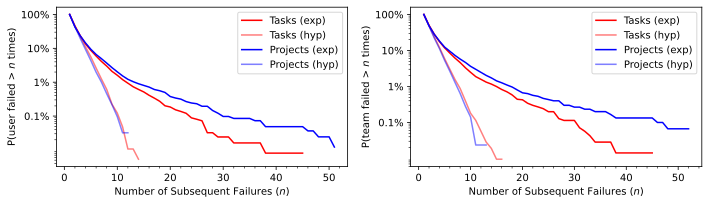

In [6]:
# Create figure with 2 subplots in one row
f, axes = plt.subplots(1, 2, figsize=(10, 3))

colors = ["red", "blue"]  # Color cycle for plotting

# Iterate over two grouping columns (e.g., 'user_id' and 'team_id')
for i_g, grp_name in enumerate(["user_id", "team_id"]):
    # Iterate over two target objects ('task_id' and 'project_id')
    for i_o, (obj_name, df_obj) in enumerate(zip(["task_id", "project_id"], [df_tasks, df_projects])):

        # Compute the streak lengths for actual data vs. random (null hypothesis)
        flr_strk = failure_streak_length(upd_df_decs, df_obj, grp_name, obj_name, "min_day_date")
        rdm_strk = failure_streak_length(upd_df_decs, df_obj, grp_name, obj_name, "min_day_date", random=True)

        # Calculate CCDF for the empirical streak lengths
        arr_flr  = range(min(flr_strk), max(flr_strk))
        ccdf_flr = ccdf(flr_strk)
        axes[i_g].plot(arr_flr, ccdf_flr,
                       label=obj_name.split("_")[0].capitalize() + "s (exp)",
                       color=colors[i_o])

        # Calculate CCDF for the random streak lengths
        arr_rdm  = range(min(rdm_strk), max(rdm_strk))
        ccdf_rdm = ccdf(rdm_strk)
        axes[i_g].plot(arr_rdm, ccdf_rdm,
                       label=obj_name.split("_")[0].capitalize() + "s (hyp)",
                       color=colors[i_o],
                       alpha=0.5)
        
        # Set log-scale for y-axis
        axes[i_g].set_yscale("log")

        # Label the axes
        axes[i_g].set_xlabel('Number of Subsequent Failures' + r' ($n$)')
        axes[i_g].set_ylabel(
            "P(%s failed > " % (grp_name.split("_")[0]) + r'$n$' + " times)"
        )

        # Configure y-axis ticks and labels
        axes[i_g].set_yticks([1e-3, 1e-2, 1e-1, 1e0])
        axes[i_g].set_yticklabels(["0.1%", "1%", "10%", "100%"])

        # Add legend
        axes[i_g].legend()

# Ensure the x-label is set for the second axis as well
axes[1].set_xlabel('Number of Subsequent Failures' + r' ($n$)')

# Adjust subplot spacing
f.tight_layout();
for ax in axes:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.minorticks_on()

f.savefig("./figures/failure_streaks.pdf", bbox_inches="tight");

In [7]:
# 1) Generate a DataFrame capturing task failure scores at the project level
glb_arr = generate_task_failure_score(df_tasks, df_projects)

# 2) Generate a DataFrame with inter-event times (IET) of task failures,
#    along with aggregated statistics (mean, standard error, etc.)
fail_iet_tot = generate_task_failure_learning(df_tasks, df_projects)

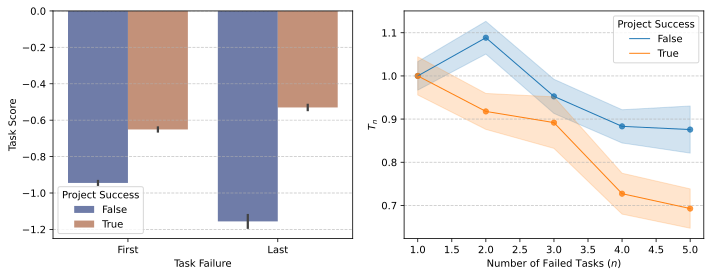

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1) Barplot of task failure scores
sns.barplot(
    data=glb_arr,
    ax=axes[0],
    x="Task Failure", 
    y="Task Score", 
    hue="Project Success", 
    errorbar="se", 
    palette="dark", 
    alpha=0.6
)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# 2) Line plot with shaded error regions for failure IET (Inter-Event Times)
colors = {True: 'tab:orange', False: 'tab:blue'}  # Color map for success status
success_categories = fail_iet_tot['success'].unique()

for success in success_categories:
    data_plot = fail_iet_tot[fail_iet_tot['success'] == success].sort_values('nb_failed_tasks')
    x_vals = data_plot['nb_failed_tasks']
    y_vals = data_plot['mean_Tn']
    yerr   = data_plot['se_Tn']

    # Plot the error region
    axes[1].fill_between(
        x_vals, 
        y_vals - yerr, 
        y_vals + yerr, 
        color=colors[success], 
        alpha=0.2
    )
    # Plot the mean line
    axes[1].plot(
        x_vals, 
        y_vals, 
        label=success, 
        color=colors[success], 
        linewidth=1
    )
    # Plot individual points
    axes[1].scatter(
        x_vals, 
        y_vals, 
        color=colors[success], 
        s=30, 
        linewidth=0.7, 
        alpha=0.8
    )

axes[1].set_xlabel('Number of Failed Tasks' + r' ($n$)')
axes[1].set_ylabel(r'$T_n$')
axes[1].legend(title='Project Success')
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

fig.tight_layout();
fig.savefig("./figures/project_task_failure.pdf", bbox_inches="tight");

In [9]:
# 1) Add project-level aggregates (distinct days & total declarations)
df_projects = df_projects.merge(
    upd_df_decs.groupby("project_id").agg(
        nb_days=('declared_at', lambda x: len(set(x))),
        nb_decs=('declared_at', len)
    ).reset_index(),
    on="project_id"
)

# 2) Compute various project-level metrics
tsks_per_prj                               = tasks_per_project(upd_df_decs)
avg_dec_tm_per_prj, avg_dly_dec_tm_per_prj = decs_stats_project(upd_df_decs)
nb_wkrs_per_prj                            = users_per_project(upd_df_decs)
mean_exp, lftm_per_prj                     = time_exp_project(upd_df_decs)
diversity                                  = diversity_project(
    upd_df_decs,
    pd.read_csv(up_DATA_DIR + "users.csv").rename({"id": "user_id"}, axis=1),
    df_projects
)

# 3) Merge all computed metrics into a single DataFrame
df_project_sup = reduce(
    lambda left, right: pd.merge(left, right, on=['project_id'], how='outer'),
    [
        tsks_per_prj,
        avg_dec_tm_per_prj, 
        avg_dly_dec_tm_per_prj,
        nb_wkrs_per_prj,
        diversity,
        mean_exp,
        lftm_per_prj
    ]
)

# 4) Create a 'full_data' DataFrame by merging with 'df_projects'
#    Include only projects having at least 5 active days
full_data = pd.merge(
    df_project_sup,
    df_projects[df_projects.nb_days >= 5][
        ["project_id", "time_success_val", "success", "nb_days", "nb_decs"]
    ],
    on="project_id"
).dropna()

# 5) Log-transform certain columns
full_data = log_cols(full_data, ["nb_tasks", "nb_users", "nb_days", "nb_decs", "lftm"])

# 6) Copy 'full_data' and normalize selected columns with z-score
norm_full_data = full_data.copy().merge(df_projects[["project_id"]], on="project_id")
norm_cols = [
    'log_nb_tasks', 'log_nb_users', 'diversity', 'mean_exp', 
    'duration', 'daily_duration', 'log_nb_days', 'log_nb_decs', 'log_lftm'
]
norm_full_data[norm_cols] = norm_full_data[norm_cols].apply(zscore)

# 7) Filter out extreme values (outliers) based on quantiles and drop remaining NaNs
filt_norm_full_data = remove_outliers(norm_full_data, norm_cols, low_qt=0.025, high_qt=0.975).dropna()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3977/3977 [00:10<00:00, 368.76it/s]


Optimization terminated successfully.
         Current function value: 0.663458
         Iterations 5


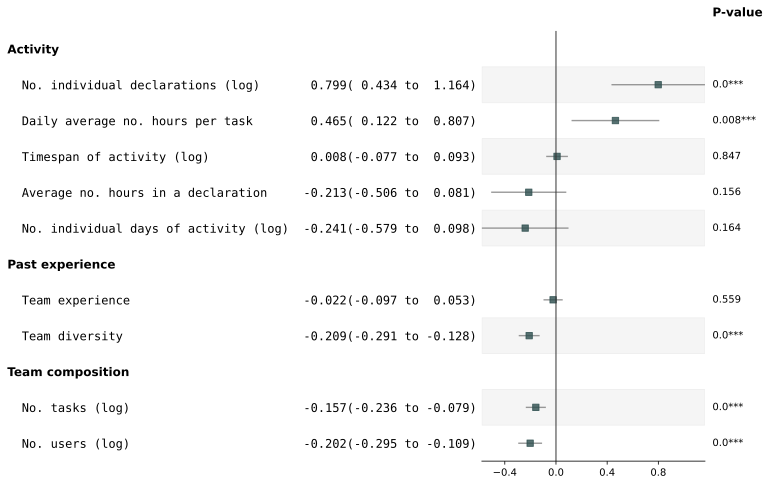

In [10]:
# 1) Prepare data for logistic regression
y = filt_norm_full_data[["project_id"]]\
    .merge(df_projects[["project_id", "failure"]])["failure"]

X = filt_norm_full_data[norm_cols].astype(np.float64)

# 2) Fit a logistic regression model
log_reg = sm.Logit(y.astype(np.int64).to_numpy(), X).fit()

# 3) Convert regression summary to a structured DataFrame
log_reg_summary = results_summary_to_dataframe(log_reg)
log_reg_summary.index.set_names(['label'], inplace=True)
log_reg_summary = log_reg_summary.reset_index()

# 4) Add grouping information and rename labels for plotting
log_reg_summary["group"] = (
    ["Team composition"] * 2  
    + ["Past experience"] * 2 
    + ["Activity"] * 5
)
log_reg_summary["label"] = [
    dic_rename[k] if k in dic_rename else k 
    for k in log_reg_summary["label"]
]

# 5) Create a forest plot using forestplot library
fp.forestplot(
    log_reg_summary,         # DataFrame with summary statistics
    estimate="r",            # Column with effect estimates
    ll="ll", hl="hl",        # Columns with lower & higher confidence limits
    varlabel="label",        # Column for variable labels
    capitalize="capitalize", # Capitalize variable labels
    groupvar="group",        # Column to group variables in plot
    sort=True,               # Sort in ascending order
    pval="p-val",            # Column to report p-values
    color_alt_rows=True,     # Alternate row background shading
    annote=["est_ci"],       # Columns reported to the left of the plot
    annoteheaders=["Est.(95% Conf. Int.)"], 
    decimal_precision=3,
    **{"ylabel1_size": 11}   # Control y-label font size
)

# 6) Tidy layout
plt.tight_layout()
plt.savefig("./figures/forest_plot.pdf", bbox_inches="tight");